# Data Understanding (Outlier)

## Deteksi Outlier

Outlier adalah data yang berbeda jauh dari pola umum dalam dataset. Penyebabnya bisa karena kesalahan pengukuran, input data yang salah, atau fenomena unik. Outlier bisa memengaruhi hasil analisis dan model machine learning, sehingga perlu dideteksi.

## K-Nearest Neighbors (KNN)

KNN bekerja dengan melihat kedekatan antar data. Dalam deteksi outlier, KNN mengukur jarak antara suatu titik dengan tetangga terdekatnya:

- Jika suatu titik hanya memiliki sedikit tetangga dalam radius tertentu, kemungkinan besar itu outlier.

- Jika jarak ke tetangga terdekat sangat besar, titik tersebut bisa dianggap sebagai outlier.

### Tahap Deteksi Outlier dengan KNN

1. Menghitung Jarak Antar Titik

- Menggunakan metrik jarak seperti Euclidean, Manhattan, atau Minkowski untuk mengukur kedekatan antar data.

2. Menentukan Nilai K (Jumlah Tetangga Terdekat)

- K terlalu kecil: terlalu sensitif terhadap noise.

- K terlalu besar: kurang akurat dalam mendeteksi outlier.

3. Menentukan Skor Outlier

- K-Nearest Neighbor Distance: Jika jarak ke K tetangga terlalu besar, kemungkinan outlier.

- Local Outlier Factor (LOF): Membandingkan kepadatan suatu titik dengan tetangganya. Jika kepadatannya lebih rendah, kemungkinan outlier.

- Distance-Based Outlier Score: Jika jumlah tetangga dalam radius tertentu sangat sedikit, bisa dianggap outlier.

### Kesimpulan

KNN bisa digunakan untuk mendeteksi outlier dengan menganalisis jarak antara titik data dan tetangganya. Metode seperti K-Nearest Neighbor Distance dan LOF membantu mengidentifikasi data yang berbeda jauh dari pola umum. Pemilihan K dan metrik jarak yang tepat sangat penting untuk akurasi deteksi outlier.

In [1]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# ✅ Fungsi untuk mengambil data dari PostgreSQL
def get_pg_data():
    conn = psycopg2.connect(
        host="pg-29vania-vaniaptr008-f94a.k.aivencloud.com",
        user="avnadmin",
        password="AVNS_jN7GWD4QIOAFWBZiFM2",
        database="defaultdb",
        port=12525
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_postgresql")  # Pastikan tabel ini ada!
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# ✅ Fungsi untuk mengambil data dari MySQL
def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-25907135-mysqql.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_-_iUzbq84ojauwfvOBS",
        database="defaultdb",
        port=12005
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_mysql")  # Pastikan tabel ini ada!
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# ✅ Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# ✅ Gabungkan berdasarkan kolom 'id' & 'class'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# ✅ Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merged[feature_columns].values

# ✅ Fungsi KNN Outlier Detection
def knn_outlier_detection(data, k=90):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    avg_distances = distances[:, -1]  # Ambil jarak k-terjauh sebagai skor
    return avg_distances

# ✅ Hitung K-NN distance
df_merged["knn_distance"] = knn_outlier_detection(data_values, k=90)

# ✅ Tentukan threshold sebagai nilai rata-rata + 2 standar deviasi
threshold = df_merged["knn_distance"].mean() + 2 * df_merged["knn_distance"].std()
df_merged["outlier_knn"] = df_merged["knn_distance"] > threshold

# ✅ Hapus data outlier
df_filtered = df_merged[~df_merged["outlier_knn"]]

# ✅ Cetak hasil setelah outlier dihapus
print(df_filtered.to_string(index=False))
print(f"\nJumlah data setelah outlier dihapus: {len(df_filtered)}")

# ✅ Visualisasi setelah outlier dihapus
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["sepal_length"], y=df_filtered["sepal_width"],
    hue=df_filtered["class"], palette="deep"
)
plt.title("Data Sepal setelah Outlier Dihapus")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["petal_length"], y=df_filtered["petal_width"],
    hue=df_filtered["class"], palette="deep"
)
plt.title("Data Petal setelah Outlier Dihapus")
plt.show()

OperationalError: (2003, "Can't connect to MySQL server on 'mysql-25907135-mysqql.h.aivencloud.com' (timed out)")

Kode ini mengambil data dari PostgreSQL dan MySQL, lalu menggabungkannya berdasarkan kolom "id" dan "class". Setelah itu, dilakukan deteksi outlier menggunakan K-Nearest Neighbors (KNN) dengan menghitung jarak rata-rata ke 90 tetangga terdekat, kemudian data dengan jarak di atas rata-rata plus 2 standar deviasi dianggap outlier dan dihapus. Terakhir, hasil data yang telah dibersihkan divisualisasikan dalam scatter plot berdasarkan fitur sepal dan petal untuk melihat perbedaan sebelum dan sesudah penghapusan outlier.

## Local Outlier Factor (LOF)

Local Outlier Factor (LOF) adalah metode berbasis kepadatan yang digunakan untuk mengidentifikasi outlier dalam suatu dataset. LOF membandingkan kepadatan lokal suatu titik dengan kepadatan lokal dari tetangganya. Jika suatu titik memiliki kepadatan yang jauh lebih rendah dibandingkan dengan sekitarnya, maka titik tersebut dianggap sebagai outlier.

LOF mengukur sejauh mana suatu titik berbeda dari tetangganya dalam hal kepadatan. Metode ini berguna dalam mendeteksi outlier karena tidak hanya mempertimbangkan jarak absolut, tetapi juga pola kepadatan lokal. LOF memberikan skor, di mana nilai lebih tinggi menunjukkan bahwa titik tersebut lebih mungkin menjadi outlier.

### Tahapan LOF

1. Menentukan jumlah tetangga (k-nearest neighbors, k): LOF membutuhkan parameter k yang menentukan jumlah tetangga yang akan dianalisis untuk setiap titik.

2. Menghitung jarak k-tetangga terdekat: Untuk setiap titik, dihitung jarak ke k tetangga terdekatnya.

3. Menentukan kepadatan lokal: Kepadatan lokal dihitung berdasarkan jarak rata-rata ke tetangga terdekat.

4. Menghitung LOF score: Perbandingan kepadatan lokal titik dengan kepadatan lokal dari tetangga-tetangganya digunakan untuk menentukan apakah suatu titik adalah outlier.

5. Menentukan threshold outlier: Biasanya, nilai LOF yang lebih tinggi dari ambang batas tertentu dianggap sebagai outlier.

### Mengitung Manual

Sebagai contoh, kita akan menghitung LOF secara manual menggunakan dataset kecil yang terdiri dari 10 baris dengan 2 fitur:

| ID | Feature 1 | Feature 2 |
| -- | --------- | --------- |
| 1  | 2.0       | 3.0       |
| 2  | 2.5       | 3.2       |
| 3  | 2.2       | 3.1       |
| 4  | 8.0       | 9.0       |
| 5  | 2.1       | 3.0       |
| 6  | 2.3       | 3.2       |
| 7  | 8.1       | 9.2       |
| 8  | 2.4       | 3.3       |
| 9  | 2.6       | 3.4       |
| 10 | 7.9       | 9.1       |

Misalkan kita ingin menghitung LOF untuk titik **ID = 3 (2.2, 3.1)**.

1. **Hitung Jarak Euclidean ke Tetangga Terdekat**:
   - Ke titik 5 (2.1, 3.0): 0.14
   - Ke titik 6 (2.3, 3.2): 0.14
   - Ke titik 2 (2.5, 3.2): 0.31

2. **Tentukan k-Tetangga Terdekat (k=3)**:
   - Tetangga terdekat: titik 5, 6, dan 2.

3. **Hitung Reachability Distance**:
   - Reachability distance dihitung sebagai maksimum antara jarak Euclidean dan jarak k-neighbor.
   - rD(3,5) = max(0.14, 0.31) = 0.31
   - rD(3,6) = max(0.14, 0.31) = 0.31
   - rD(3,2) = max(0.31, 0.31) = 0.31

4. **Hitung Local Reachability Density (LRD)**:

   ![image.png](image1.png)

5. **Hitung LOF**:

![image.png](image2.png)

7. **Interpretasi**:
   - Karena **LOF < 1**, titik **ID = 3** bukan outlier.
   - Jika LOF jauh lebih besar dari 1, titik akan dianggap outlier.

### Implementasi LOF menggunakan Scikit-Learn

In [4]:
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

# Dataset
data = {
    "Feature 1": [2.0, 2.5, 2.2, 8.0, 2.1, 2.3, 8.1, 2.4, 2.6, 7.9],
    "Feature 2": [3.0, 3.2, 3.1, 9.0, 3.0, 3.2, 9.2, 3.3, 3.4, 9.1]
}
df = pd.DataFrame(data)

# Model LOF
lof = LocalOutlierFactor(n_neighbors=3)
df["LOF Label"] = lof.fit_predict(df)

# Menampilkan jumlah outlier
num_outliers = (df["LOF Label"] == -1).sum()
print(f"\nJumlah outlier: {num_outliers}")

# Menampilkan data outlier
outliers = df[df['LOF Label'] == -1]
print("\nData Outlier:")
print(outliers)


Jumlah outlier: 3

Data Outlier:
   Feature 1  Feature 2  LOF Label
3        8.0        9.0         -1
6        8.1        9.2         -1
9        7.9        9.1         -1


Kode di atas menggunakan metode **Local Outlier Factor (LOF)** dari pustaka `scikit-learn` untuk mendeteksi **outlier** dalam dataset. Dataset terdiri dari dua fitur dengan 10 sampel yang disimpan dalam bentuk `DataFrame`. Model LOF dibuat dengan mempertimbangkan **3 tetangga terdekat** (`n_neighbors=3`) untuk menghitung kepadatan lokal setiap titik. Hasil perhitungan LOF mengembalikan label `1` untuk data normal dan `-1` untuk data yang dianggap **outlier**. Setelah itu, kode menghitung jumlah outlier dan menampilkan daftar sampel yang terdeteksi sebagai **outlier** berdasarkan skor LOF. Dengan pendekatan ini, kita dapat mengidentifikasi data yang berbeda secara signifikan dari sekitarnya, yang berguna dalam **analisis data** dan **pembersihan dataset**.

## Klasifikasi Dengan KNN

### Memisahkan Outlier Dari Data

In [13]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# ✅ Fungsi untuk mengambil data dari PostgreSQL
def get_pg_data():
    conn = psycopg2.connect(
        host="pg-29vania-vaniaptr008-f94a.k.aivencloud.com",
        user="avnadmin",
        password="AVNS_jN7GWD4QIOAFWBZiFM2",
        database="defaultdb",
        port=12525
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_postgresql")  # Pastikan tabel ini ada!
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# ✅ Fungsi untuk mengambil data dari MySQL
def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-25907135-mysqql.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_-_iUzbq84ojauwfvOBS",
        database="defaultdb",
        port=12005
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_mysql")  # Pastikan tabel ini ada!
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# ✅ Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'class'
df_merge = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik tanpa kolom 'class'
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merge[feature_columns].values

# Inisialisasi model LOF
clf = LocalOutlierFactor(n_neighbors=90)
label = clf.fit_predict(data_values)

# Tambahkan hasil label ke dataframe
df_merge["outlier_label"] = label

# Cetak hasil dengan ID dan class
print(df_merge.to_string(index=False))

num_outliers = (label == -1).sum()
print(f"\nJumlah outlier: {num_outliers}")
df_filtered = df_merge[label == 1].drop(columns=["outlier_label"], errors='ignore')
outliers = df_merge[label == -1].drop(columns=["outlier_label"], errors='ignore')
print("\nData Outlier:")
print(outliers.to_string(index=False))
print("\nJumlah data setelah dihapus : ",len(df_filtered))
print("\nData tidak outlier :")
print(df_filtered.to_string(index=False))

 id           class  petal_length  petal_width  sepal_length  sepal_width  outlier_label
  1     Iris-setosa          14.0          2.0          51.0         35.0             -1
  2     Iris-setosa          14.0          2.0          49.0         30.0             -1
  3     Iris-setosa          13.0          2.0          47.0         32.0             -1
  4     Iris-setosa          15.0          2.0          46.0         31.0             -1
  5     Iris-setosa          14.0          2.0           5.0         36.0             -1
  6     Iris-setosa           1.7          0.4           5.4          3.9              1
  7     Iris-setosa           1.4          0.3           4.6          3.4              1
  8     Iris-setosa           1.5          0.2           5.0          3.4              1
  9     Iris-setosa           1.4          0.2           4.4          2.9              1
 10     Iris-setosa           1.5          0.1          94.0          3.1             -1
 11     Iris-setosa  

Kode ini mengambil data dari PostgreSQL dan MySQL, lalu menggabungkannya berdasarkan kolom **"id"** dan **"class"**. Setelah itu, digunakan algoritma **Local Outlier Factor (LOF)** dengan **90 tetangga terdekat** untuk mendeteksi outlier berdasarkan fitur numerik **(petal_length, petal_width, sepal_length, sepal_width)**. Data yang memiliki label **-1** dianggap sebagai outlier, sementara data dengan label **1** dianggap normal. Hasilnya ditampilkan dalam dua kelompok: **data outlier** dan **data yang tidak outlier**, beserta jumlahnya setelah outlier dihapus.

### Menghitung Akurasi

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=90, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Pisahkan data dengan outlier dan tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),
    test_size=0.2,
    random_state=42
)

# Pipeline dengan StandardScaler dan KNN
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Latih model pada data dengan outlier
knn_pipeline.fit(X_train_all, y_train_all)
y_pred_all = knn_pipeline.predict(X_test_all)
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Akurasi dengan outlier:", accuracy_all)
print(classification_report(y_test_all, y_pred_all, target_names=label_encoder.classes_))

# Latih model pada data tanpa outlier
knn_pipeline.fit(X_train_clean, y_train_clean)
y_pred_clean = knn_pipeline.predict(X_test_clean)
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Akurasi tanpa outlier:", accuracy_clean)
print(classification_report(y_test_clean, y_pred_clean, target_names=label_encoder.classes_))

Akurasi dengan outlier: 0.8666666666666667
                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.70      0.82        10
Iris-versicolor       0.82      1.00      0.90         9
 Iris-virginica       0.83      0.91      0.87        11

       accuracy                           0.87        30
      macro avg       0.88      0.87      0.86        30
   weighted avg       0.88      0.87      0.86        30

Akurasi tanpa outlier: 1.0
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      1.00      1.00         6
 Iris-virginica       1.00      1.00      1.00         8

       accuracy                           1.00        27
      macro avg       1.00      1.00      1.00        27
   weighted avg       1.00      1.00      1.00        27



Kode ini melakukan **deteksi outlier** menggunakan **Local Outlier Factor (LOF)** dan mengevaluasi dampaknya terhadap **akurasi model K-Nearest Neighbors (KNN)** dalam klasifikasi data **Iris**. Pertama, fitur numerik **(X)** dan label kelas **(y)** diekstrak dari data, lalu label kelas dikonversi ke bentuk numerik dengan **LabelEncoder**. LOF diterapkan untuk mengidentifikasi **outlier**, di mana data dengan label **-1** dianggap sebagai outlier dan dihapus, sehingga terbentuk **df_cleaned** (data tanpa outlier). Data kemudian dibagi menjadi **80% training dan 20% testing**, baik untuk data asli (dengan outlier) maupun data yang telah dibersihkan dari outlier. Model **KNN dengan k=11** diterapkan menggunakan **pipeline yang mencakup StandardScaler**, lalu dilatih dan dievaluasi pada kedua versi data. Hasil evaluasi menunjukkan perbandingan **akurasi sebelum dan sesudah menghapus outlier**, dengan **classification_report** yang memberikan metrik klasifikasi seperti precision, recall, dan f1-score.

### Visualisasi 

Akurasi: 1.0
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      1.00      1.00         6
 Iris-virginica       1.00      1.00      1.00         8

       accuracy                           1.00        27
      macro avg       1.00      1.00      1.00        27
   weighted avg       1.00      1.00      1.00        27



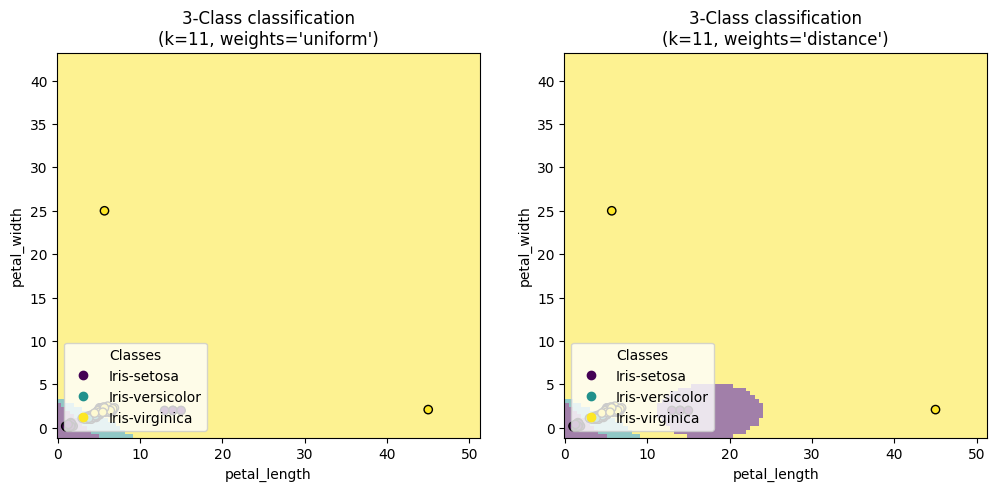

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["petal_length", "petal_width"]
X = df_cleaned[feature_columns]
y = df_cleaned["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Ubah nama kelas jadi angka

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

Kode ini melakukan klasifikasi menggunakan algoritma K-Nearest Neighbors (KNN) dengan dua fitur utama (petal_length dan petal_width) dari dataset yang sudah dibersihkan dari outlier. Data terlebih dahulu diencode menggunakan LabelEncoder, lalu dibagi menjadi 80% training dan 20% testing. Model KNN diterapkan dalam pipeline bersama StandardScaler untuk menstandarisasi data, kemudian dilatih dengan 11 tetangga terdekat (n_neighbors=11). Evaluasi model dilakukan dengan akurasi dan classification report. Terakhir, kode membuat visualisasi decision boundary dari model KNN dengan dua skenario pembobotan (uniform dan distance), menggunakan DecisionBoundaryDisplay untuk menggambarkan bagaimana model membedakan kelas berdasarkan fitur yang dipilih.

Akurasi: 0.7037037037037037
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         9
Iris-versicolor       0.62      0.50      0.56        10
 Iris-virginica       0.50      0.62      0.56         8

       accuracy                           0.70        27
      macro avg       0.71      0.71      0.70        27
   weighted avg       0.71      0.70      0.70        27



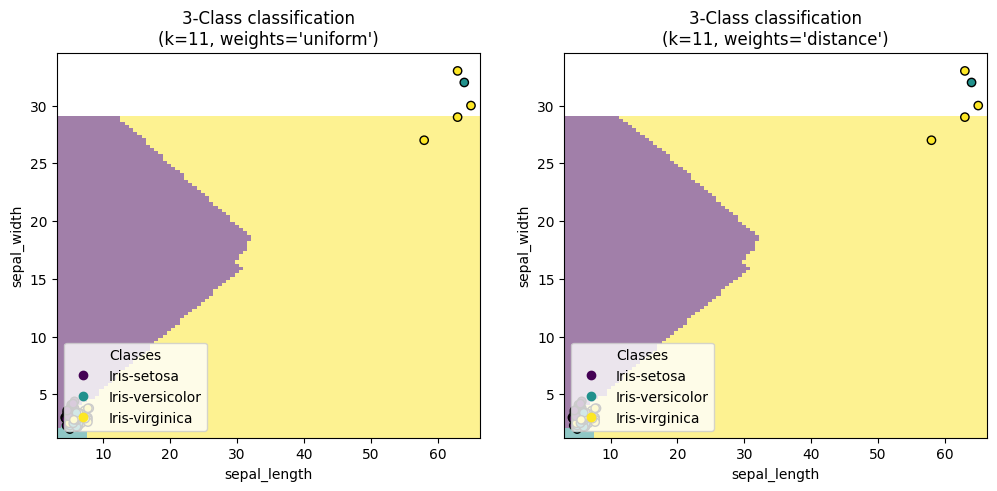

In [71]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay


# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["sepal_length", "sepal_width"]
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Mengubah nama kelas menjadi angka

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Menghapus data yang terdeteksi sebagai outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),  # Pastikan target dalam bentuk numerik
    test_size=0.2,
    random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

Kode ini melakukan deteksi outlier dengan LOF dan klasifikasi dengan KNN menggunakan fitur sepal_length dan sepal_width. Pertama, data dikodekan menggunakan LabelEncoder, lalu outlier diidentifikasi dengan Local Outlier Factor (LOF) menggunakan 20 tetangga (n_neighbors=20) dan 10% data dianggap outlier (contamination=0.1). Data yang terdeteksi sebagai outlier dihapus sebelum digunakan dalam pembagian data training (80%) dan testing (20%). Model KNN dengan 11 tetangga (n_neighbors=11) diterapkan dalam pipeline bersama StandardScaler, lalu dilatih dan dievaluasi menggunakan akurasi dan classification report. Terakhir, kode membuat visualisasi decision boundary dengan dua skenario bobot (uniform dan distance), menunjukkan bagaimana model memisahkan kelas berdasarkan fitur yang dipilih.

## Klasifikasi  Dengan Naive Baiyes

### Menyiapkan Data

In [23]:
from sklearn.preprocessing import LabelEncoder

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
df_merged["class_encoded"] = label_encoder.fit_transform(df_merged["class"])

# Data dengan outlier
X_all = df_merged[feature_columns]
y_all = df_merged["class_encoded"].values  # Pastikan dalam bentuk array numpy

# Data tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])
X_clean = df_cleaned[feature_columns]
y_clean = df_cleaned["class_encoded"].values  # Pastikan dalam bentuk array numpy

Kode ini mengonversi label kelas menjadi numerik menggunakan LabelEncoder() agar dapat digunakan dalam model machine learning. Setelah itu, dataset dibagi menjadi dua bagian: satu dengan outlier dan satu tanpa outlier. Dataset dengan outlier disimpan dalam X_all untuk fitur dan y_all untuk label kelas yang telah dikonversi. Sementara itu, dataset tanpa outlier difilter dengan hanya menyertakan baris di mana outlier == 1, lalu kolom outlier dihapus. Data hasil pembersihan ini disimpan dalam X_clean untuk fitur dan y_clean untuk label kelas dalam bentuk numerik, memastikan bahwa analisis dapat dilakukan baik dengan maupun tanpa outlier.

### Pelatihan, Pengujian, dan Evaluasi Model Naïve Bayes

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split data dengan outlier
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42)

# Split data tanpa outlier
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42)

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Inisialisasi model Naive Bayes
gnb = GaussianNB()

# Latih dan uji model dengan outlier
y_pred_all = gnb.fit(X_train_all, y_train_all).predict(X_test_all)
accuracy_all = accuracy_score(y_test_all, y_pred_all)

# Latih dan uji model tanpa outlier
y_pred_clean = gnb.fit(X_train_clean, y_train_clean).predict(X_test_clean)
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)

# Evaluasi model dengan outlier
mislabeled_all = (y_test_all != y_pred_all).sum()
print("Jumlah data yang salah diklasifikasikan dengan outlier dari total %d data : %d" % (X_test_all.shape[0], mislabeled_all))
print("Akurasi dengan outlier: %.2f%%" % (accuracy_all * 100))

# Menampilkan label yang salah pada data dengan outlier
mislabeled_indices_all = np.where(y_test_all != y_pred_all)[0]
print("Data yang salah diklasifikasikan dengan outlier:")
for i in mislabeled_indices_all:
    true_label = label_encoder.inverse_transform([int(y_test_all[i])])[0]
    predicted_label = label_encoder.inverse_transform([int(y_pred_all[i])])[0]
    print(f"Indeks: {i}, Label Asli: {true_label}, Prediksi: {predicted_label}")
print()

# Evaluasi model tanpa outlier
mislabeled_clean = (y_test_clean != y_pred_clean).sum()
print("Jumlah data yang salah diklasifikasikan tanpa outlier dari total %d data : %d" % (X_test_clean.shape[0], mislabeled_clean))
print("Akurasi tanpa outlier: %.2f%%" % (accuracy_clean * 100))

# Menampilkan label yang salah pada data tanpa outlier
mislabeled_indices_clean = np.where(y_test_clean != y_pred_clean)[0]
print("Data yang salah diklasifikasikan tanpa outlier:")
for i in mislabeled_indices_clean:
    true_label = label_encoder.inverse_transform([int(y_test_clean[i])])[0]
    predicted_label = label_encoder.inverse_transform([int(y_pred_clean[i])])[0]
    print(f"Indeks: {i}, Label Asli: {true_label}, Prediksi: {predicted_label}")

Jumlah data yang salah diklasifikasikan dengan outlier dari total 30 data : 19
Akurasi dengan outlier: 36.67%
Data yang salah diklasifikasikan dengan outlier:
Indeks: 0, Label Asli: Iris-versicolor, Prediksi: Iris-setosa
Indeks: 2, Label Asli: Iris-virginica, Prediksi: Iris-versicolor
Indeks: 3, Label Asli: Iris-versicolor, Prediksi: Iris-setosa
Indeks: 4, Label Asli: Iris-versicolor, Prediksi: Iris-setosa
Indeks: 6, Label Asli: Iris-versicolor, Prediksi: Iris-setosa
Indeks: 7, Label Asli: Iris-virginica, Prediksi: Iris-versicolor
Indeks: 8, Label Asli: Iris-versicolor, Prediksi: Iris-setosa
Indeks: 9, Label Asli: Iris-versicolor, Prediksi: Iris-setosa
Indeks: 10, Label Asli: Iris-virginica, Prediksi: Iris-versicolor
Indeks: 15, Label Asli: Iris-versicolor, Prediksi: Iris-setosa
Indeks: 17, Label Asli: Iris-versicolor, Prediksi: Iris-setosa
Indeks: 18, Label Asli: Iris-versicolor, Prediksi: Iris-setosa
Indeks: 19, Label Asli: Iris-virginica, Prediksi: Iris-versicolor
Indeks: 21, Label 

Kode ini melakukan evaluasi model Naïve Bayes pada dataset dengan dan tanpa outlier untuk membandingkan akurasi klasifikasinya. Pertama, dataset dibagi menjadi data latih dan data uji menggunakan train_test_split, baik untuk data yang mengandung outlier maupun yang telah dibersihkan dari outlier. Model Naïve Bayes (GaussianNB) kemudian dilatih dan diuji pada kedua versi dataset, dengan hasil prediksi dibandingkan dengan label sebenarnya menggunakan metrik accuracy_score. Jumlah data yang salah diklasifikasikan dihitung dan ditampilkan untuk kedua skenario, serta akurasinya dalam persentase. Selain itu, kode juga mengidentifikasi dan mencetak indeks serta label dari data yang diklasifikasikan secara salah dalam kedua kondisi, dengan menerjemahkan label numerik kembali ke bentuk aslinya menggunakan LabelEncoder. Tujuan dari proses ini adalah untuk memahami dampak keberadaan outlier terhadap performa model, di mana hasil akhirnya menunjukkan perbandingan akurasi dan jumlah kesalahan klasifikasi dengan dan tanpa outlier.

### Visualisasi Confussion Matrix

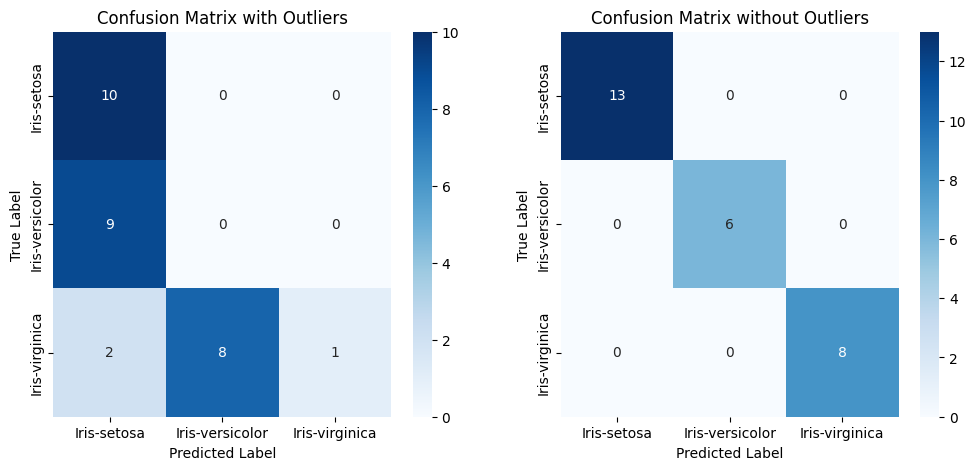

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix dengan outlier
sns.heatmap(confusion_matrix(y_test_all, y_pred_all), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix with Outliers")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Confusion Matrix tanpa outlier
sns.heatmap(confusion_matrix(y_test_clean, y_pred_clean), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix without Outliers")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()

Kode ini bertujuan untuk memvisualisasikan performa model Naïve Bayes menggunakan confusion matrix dalam dua kondisi: dengan dan tanpa outlier. Menggunakan matplotlib dan seaborn, dua confusion matrix dibuat dalam satu figure dengan dua subplot yang bersebelahan. Masing-masing confusion matrix menggambarkan perbandingan antara label sebenarnya (y_test_all atau y_test_clean) dengan hasil prediksi model (y_pred_all atau y_pred_clean). Warna biru digunakan untuk memperjelas jumlah prediksi dalam tiap kategori, dan nilai prediksi ditampilkan dalam setiap sel menggunakan annot=True. Sumbu horizontal merepresentasikan label yang diprediksi, sementara sumbu vertikal menunjukkan label sebenarnya. Dengan visualisasi ini, kita dapat melihat pola kesalahan klasifikasi dan membandingkan bagaimana keberadaan outlier mempengaruhi kinerja model.